<h1><center>My Reddit monitoring dashboard for Python 🐍</center></h1>


<center><i>A simple dashboard to monitor keywords in Reddit, made by <a href="https://duarteocarmo.com/">Duarte OC</a> with <a href="https://github.com/voila-dashboards/voila">Voila</a>, <a href="https://pandas.pydata.org/">Pandas</a>, <a href="https://plot.ly/python/plotly-express/">Plotly Express</a> and <a href="https://textblob.readthedocs.io/en/dev/">TextBlob</a>.</i></center>

<center><i><a href="https://github.com/duarteocarmo/interactive-dashboard-post">Source code on github</a></i></center>

In [3]:
# import libraries

import requests
import pandas
import textblob
import plotly.express as px
import nltk
nltk.download('punkt')
pandas.set_option('display.max_colwidth', -1) # don't cut my pandas dataframes

[nltk_data] Downloading package punkt to /home/doc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# define variables

COMMENT_COLOR         = "blueviolet"
SUBMISSION_COLOR      = "darkorange"
TEXT_PREVIEW_SIZE     = 240
TERM_OF_INTEREST      = "python"
SUBREDDIT_OF_INTEREST = "python"
TIMEFRAME             = "48h"

In [17]:
# a couple of helper functions

def get_pushshift_data(data_type, **kwargs):
    """
    Gets data from the pushshift api.
    
    Data type can be 'comment' or 'submission'
    The rest of the args as interpreted as payload.
    
    Read more: https://github.com/pushshift/api
    """
    
    base_url = f"https://api.pushshift.io/reddit/search/{data_type}/"
    payload = kwargs
    
    request = requests.get(base_url, params=payload)
    
    return request.json()


def make_clickable(val):
    """
    Makes a pandas column clickable.
    """
    
    return '<a href="{}">Link</a>'.format(val)

# Figure Index

- [Comment activity](#1)
- [Submission activity](#2)
- [Most upvoted comments](#3) 
- [Most upvoted submissions](#4) 
- [/r/python comment sentiment timeline](#5)

## Comment activity <a class="anchor" id="1"></a>

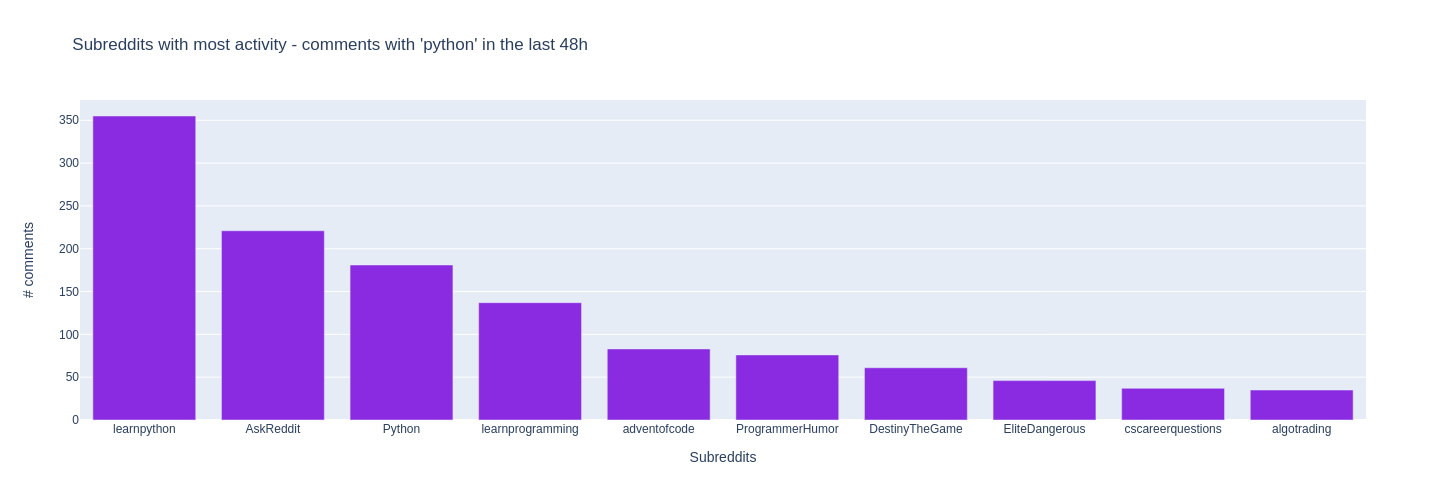

In [18]:
data = get_pushshift_data(data_type="comment", q=TERM_OF_INTEREST, after=TIMEFRAME, size=1000, aggs="subreddit").get("aggs").get("subreddit")

df = pandas.DataFrame.from_records(data)[0:10]

px.bar(df,
       x="key",
       y="doc_count",
       title=f"Subreddits with most activity - comments with '{TERM_OF_INTEREST}' in the last {TIMEFRAME}",
       labels={"doc_count": "# comments","key": "Subreddits"},
       color_discrete_sequence=[COMMENT_COLOR],
       height=500,
       width=800)

## Submission activity <a class="anchor" id="2"></a>

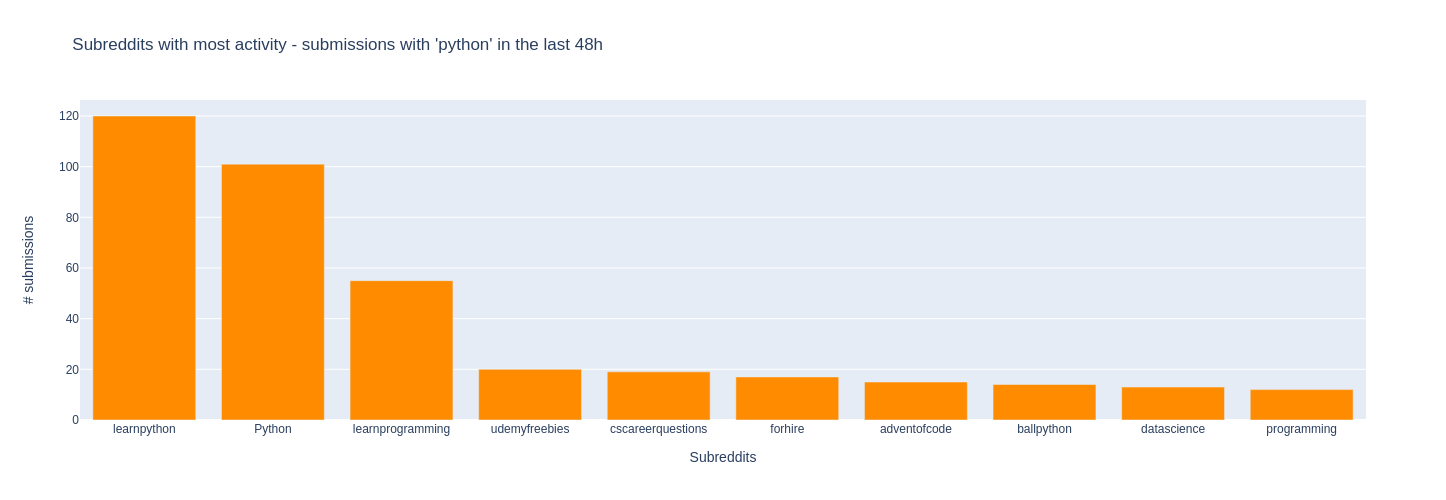

In [19]:
data = get_pushshift_data(data_type="submission", q=TERM_OF_INTEREST, after=TIMEFRAME, size=1000, aggs="subreddit").get("aggs").get("subreddit")
df = pandas.DataFrame.from_records(data)[0:10]
px.bar(df,
       x="key",
       y="doc_count",
       title=f"Subreddits with most activity - submissions with '{TERM_OF_INTEREST}' in the last {TIMEFRAME}",
       labels={"doc_count": "# submissions","key": "Subreddits"},
       color_discrete_sequence=[SUBMISSION_COLOR],
       height=500,
       width=800)

## Most upvoted comments <a class="anchor" id="3"></a>

In [22]:
data = get_pushshift_data(data_type="comment", q=TERM_OF_INTEREST, after="7d", size=10, sort_type="score", sort="desc").get("data")
# to see what columns interest you, simply list(df)
df = pandas.DataFrame.from_records(data)[["author", "subreddit", "score", "body", "permalink"]]

# we only keep the first X characters of the body 
df.body = df.body.str[0:50] + "..."

# we append the string to all the permalink entries
df.permalink = "https://reddit.com" + df.permalink.astype(str)

# print 
print(f"\nTop 10 most upvoted comments with '{TERM_OF_INTEREST}' in the past {TIMEFRAME}\n")

# style the last column to be clickable and print
df.style.format({'permalink': make_clickable})


Top 10 most upvoted comments with 'python' in the past 48h



,author,subreddit,score,body,permalink
0,Saiboo,learnpython,111,Suppose you create the following python file calle...,Link
1,Kompakt,ProgrammerHumor,92,Some languages don't have switch statements...look...,Link
2,clown_world_2020,MrRobot,47,Just goes to show that Esmail isn't the only brill...,Link
3,Leebertysauce,AnimalsBeingBros,28,They wont even be mad when the python decide to ta...,Link
4,Kompakt,ProgrammerHumor,23,"Yep it's true, and depending on the design of the ...",Link
5,niceboy4431,Cringetopia,23,I have a theory (someone prove me wrong if you kno...,Link
6,kingguru,Denmark,22,Brug af Python: **+1** Brug af Python 3: **+2** ...,Link
7,MintyAroma,totalwar,20,We really need Bretonnian Men-At-Arms shouting Mon...,Link
8,aspiringtobeme,gifsthatkeepongiving,19,Amazing. Brought [this Monty Python clip](https://...,Link
9,CrimsonSpooker,TwoBestFriendsPlay,19,“Why can’t Three Houses be gritty and “realistic” ...,Link


## Most upvoted submissions <a class="anchor" id="4"></a>

In [21]:
data = get_pushshift_data(data_type="submission", q=TERM_OF_INTEREST, after=TIMEFRAME, size=10, sort_type="score", sort="desc").get("data")
# to see what columns interest you, simply list(df)
df = pandas.DataFrame.from_records(data)[["author", "subreddit", "score", "title", "permalink"]]

# we only keep the first X characters of the body 
df.title = df.title[0:240] + "..."

# we append the string to all the permalink entries
df.permalink = "https://reddit.com" + df.permalink.astype(str)

# print 
print(f"\nTop 10 most upvoted submissions with '{TERM_OF_INTEREST}' in the past {TIMEFRAME}\n")

# style the last column to be clickable and print
df.style.format({'permalink': make_clickable})


Top 10 most upvoted submissions with 'python' in the past 48h



,author,subreddit,score,title,permalink
0,smallabc,Python,1,"Auto-copy all displayed ""print"" results into clipboard?...",Link
1,amoh-godwin,u_amoh-godwin,1,$0 - Free Udemy course coupon - FREE for THREE DAYS...,Link
2,KameNoKami91,proceduralgeneration,1,Python World Generation with falloff gradient manipulation...,Link
3,italiagram3,ItaliaGram,1,[ItalyInformatica] Cosa dovrei utilizzare per realizzare un grafico sequenziale?...,Link
4,bransongilly,snakes,1,"I got a Indonesian reticulating python, I’m a first time snake owner so any advice or tips welcome, haven’t named him yet either, here’s snake boi...",Link
5,missfusion,learnprogramming,1,Complete beginner python tutorial Recommendations...,Link
6,invisibleinfant,AIDungeon,1,Anyone get this to run in docker yet with CUDA?...,Link
7,AdoptanIntern,GraduateRecruitmentUK,1,Systems Engineer with New Verve Consulting...,Link
8,up32835,visualization,1,VISUALIZING MY LINKEDIN NETWORK ON A GRAPH...,Link
9,itwasntzak,learnprogramming,1,Git Directory on Computer...,Link


In [24]:
import textblob

sentence1 = "Portugal is a horrible country. People drive like crazy animals."
print(textblob.TextBlob(sentence1).sentiment)


sentence2 = "Portugal is the most beautiful country in the world because "
print(textblob.TextBlob(sentence2).sentiment)


Sentiment(polarity=-0.8, subjectivity=0.95)
Sentiment(polarity=0.6062500000000001, subjectivity=0.6666666666666666)


## /r/python comment sentiment timeline <a class="anchor" id="5"></a>

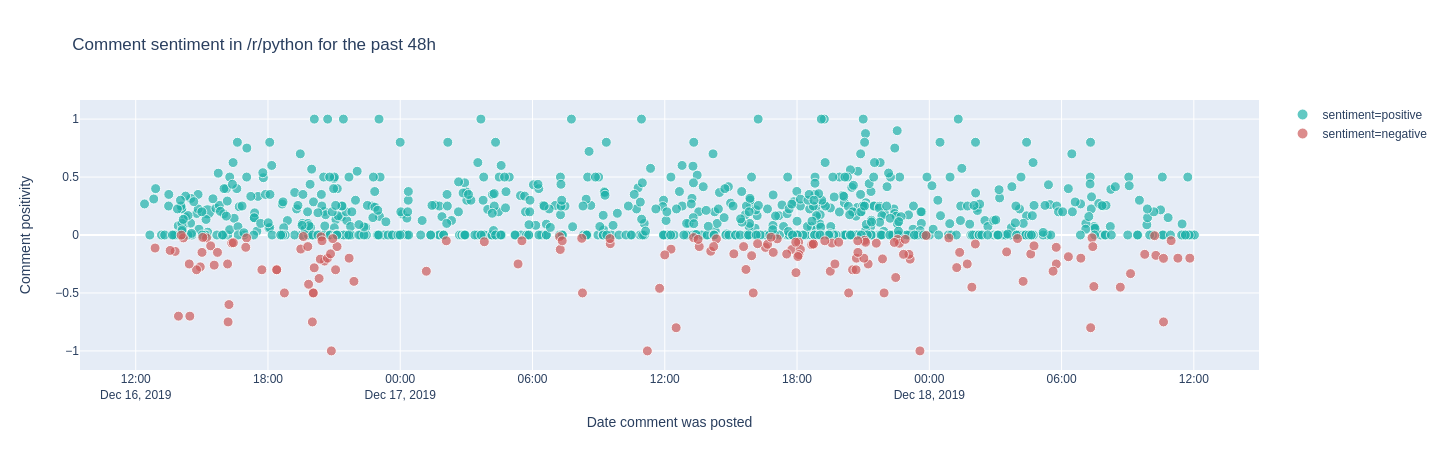

In [127]:
data = get_pushshift_data(data_type="comment", after=TIMEFRAME, size=1000, sort_type="score", sort="desc", subreddit=SUBREDDIT_OF_INTEREST).get("data")
df = pandas.DataFrame.from_records(data)[["author", "body", "created_utc", "score", "permalink"]]

df["sentiment_polarity"] = df.apply(lambda row: textblob.TextBlob(row["body"]).sentiment.polarity, axis=1)
df["sentiment_subjectivity"] = df.apply(lambda row: textblob.TextBlob(row["body"]).sentiment.subjectivity, axis=1)
df["sentiment"] = df.apply(lambda row: "positive" if row["sentiment_polarity"] >= 0 else "negative", axis=1)

df["preview"] = df["body"].str[0:50]

df["date"] = pandas.to_datetime(df['created_utc'],unit='s')

px.scatter(df, x="date", 
               y="sentiment_polarity",
               hover_data=["author", "permalink", "preview"],
               color_discrete_sequence=["lightseagreen", "indianred"],
               color="sentiment",
               size="score",
               size_max=10,
               labels={"sentiment_polarity": "Comment positivity", "date": "Date comment was posted"},
               title=f"Comment sentiment in /r/{SUBREDDIT_OF_INTEREST} for the past {TIMEFRAME}",
          )


<p><center>Made with 🐍 and 🍕 by <a href="https://duarteocarmo.com">Duarte OC</a></center></p>